In [1]:
import os, sys
from google.colab import drive
from pathlib import Path

NOTEBOOK_NAME = "MLAP_test_eval"

# --- do not change below this ---
DRIVE_PATH = "/content/drive/"
drive.mount(DRIVE_PATH, force_remount=True)

# shell commands for directory with space must be
# quoted, but not necessary in python
COLAB_PATH = "Colab Notebooks"
COLLAB_PATH_ESC = f"\"{COLAB_PATH}\""

# python path
nb_path = (
    "/".join(('drive/MyDrive', 
              COLAB_PATH, 
              "venv_" + NOTEBOOK_NAME)
    )
)

# shell path
nb_path_bash = (
    "/".join(('drive/MyDrive', 
              COLLAB_PATH_ESC, 
              "venv_" + NOTEBOOK_NAME)
    )
)


try:
  os.makedirs(nb_path)
except FileExistsError:
  # already created in G-drive
  print("Google Drive Folder already existed.")

try:
  # create symlink from drive to workspace
  os.symlink(nb_path, "/content/notebooks")
except FileExistsError:
  # already created in G-drive
  print("Symlink already existed.")

sys.path.insert(0, nb_path)

Mounted at /content/drive/
Google Drive Folder already existed.


In [3]:
!pip install --quiet torch_geometric ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Encoder

In [4]:
import numpy as np
import torch
from torch_geometric.utils import dropout_edge, degree, to_undirected, scatter, to_networkx

class ASTNodeEncoder(torch.nn.Module):
    '''
        Input:
            x: default node feature. the first and second column represents node type and node attributes.
            depth: The depth of the node in the AST.

        Output:
            emb_dim-dimensional vector

    '''
    def __init__(self, emb_dim, num_nodetypes, num_nodeattributes, max_depth):
        super(ASTNodeEncoder, self).__init__()

        self.max_depth = max_depth

        self.type_encoder = torch.nn.Embedding(num_nodetypes, emb_dim)
        self.attribute_encoder = torch.nn.Embedding(num_nodeattributes, emb_dim)
        self.depth_encoder = torch.nn.Embedding(self.max_depth + 1, emb_dim)

        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(3 * emb_dim, 2 * emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * emb_dim, emb_dim),
        )

    def forward(self, x, depth):
        depth[depth > self.max_depth] = self.max_depth
        mlp_input = torch.hstack(
            (
                self.type_encoder(x[:,0]), 
                self.attribute_encoder(x[:,1]), 
                self.depth_encoder(depth)
             )
        )
        return self.node_mlp(mlp_input)

### Utils - AST / MLAP

Utilities for editing and parsing the AST inputs.

In [5]:
import numpy as np
import torch
from torch_geometric.utils import dropout_edge, degree, to_undirected, scatter, to_networkx
import networkx as nx

def get_vocab_mapping(seq_list, num_vocab):
    '''
        Input:
            seq_list: a list of sequences
            num_vocab: vocabulary size
        Output:
            vocab2idx:
                A dictionary that maps vocabulary into integer index.
                Additioanlly, we also index '__UNK__' and '__EOS__'
                '__UNK__' : out-of-vocabulary term
                '__EOS__' : end-of-sentence

            idx2vocab:
                A list that maps idx to actual vocabulary.
    '''

    vocab_cnt = {}
    vocab_list = []
    for seq in seq_list:
        for w in seq:
            if w in vocab_cnt:
                vocab_cnt[w] += 1
            else:
                vocab_cnt[w] = 1
                vocab_list.append(w)

    cnt_list = np.array([vocab_cnt[w] for w in vocab_list])
    topvocab = np.argsort(-cnt_list, kind = 'stable')[:num_vocab]

    print('Coverage of top {} vocabulary:'.format(num_vocab))
    print(float(np.sum(cnt_list[topvocab]))/np.sum(cnt_list))

    vocab2idx = {vocab_list[vocab_idx]: idx for idx, vocab_idx in enumerate(topvocab)}
    idx2vocab = [vocab_list[vocab_idx] for vocab_idx in topvocab]

    vocab2idx['__UNK__'] = num_vocab
    idx2vocab.append('__UNK__')

    vocab2idx['__EOS__'] = num_vocab + 1
    idx2vocab.append('__EOS__')

    # test the correspondence between vocab2idx and idx2vocab
    for idx, vocab in enumerate(idx2vocab):
        assert(idx == vocab2idx[vocab])

    # test that the idx of '__EOS__' is len(idx2vocab) - 1.
    # This fact will be used in decode_arr_to_seq, when finding __EOS__
    assert(vocab2idx['__EOS__'] == len(idx2vocab) - 1)

    return vocab2idx, idx2vocab

def augment_edge(data):
    '''
        Input:
            data: PyG data object
        Output:
            data (edges are augmented in the following ways):
                data.edge_index: Added next-token edge. The inverse edges were also added.
                data.edge_attr (torch.Long):
                    data.edge_attr[:,0]: whether it is AST edge (0) for next-token edge (1)
                    data.edge_attr[:,1]: whether it is original direction (0) or inverse direction (1)
    '''
    ##### AST edge
    edge_index_ast = data.edge_index
    edge_attr_ast = torch.zeros((edge_index_ast.size(1), 2))

    ##### Inverse AST edge
    edge_index_ast_inverse = torch.stack([edge_index_ast[1], edge_index_ast[0]], dim = 0)
    edge_attr_ast_inverse = torch.cat([torch.zeros(edge_index_ast_inverse.size(1), 1), torch.ones(edge_index_ast_inverse.size(1), 1)], dim = 1)

    ##### Next-token edge

    ## Obtain attributed nodes and get their indices in dfs order
    # attributed_node_idx = torch.where(data.node_is_attributed.view(-1,) == 1)[0]
    # attributed_node_idx_in_dfs_order = attributed_node_idx[torch.argsort(data.node_dfs_order[attributed_node_idx].view(-1,))]

    ## Since the nodes are already sorted in dfs ordering in our case, we can just do the following.
    attributed_node_idx_in_dfs_order = torch.where(data.node_is_attributed.view(-1,) == 1)[0]

    ## build next token edge
    # Given: attributed_node_idx_in_dfs_order
    #        [1, 3, 4, 5, 8, 9, 12]
    # Output:
    #    [[1, 3, 4, 5, 8, 9]
    #     [3, 4, 5, 8, 9, 12]
    edge_index_nextoken = torch.stack([attributed_node_idx_in_dfs_order[:-1], attributed_node_idx_in_dfs_order[1:]], dim = 0)
    edge_attr_nextoken = torch.cat([torch.ones(edge_index_nextoken.size(1), 1), torch.zeros(edge_index_nextoken.size(1), 1)], dim = 1)

    ##### Inverse next-token edge
    edge_index_nextoken_inverse = torch.stack([edge_index_nextoken[1], edge_index_nextoken[0]], dim = 0)
    edge_attr_nextoken_inverse = torch.ones((edge_index_nextoken.size(1), 2))

    data.edge_index = torch.cat([edge_index_ast, edge_index_ast_inverse, edge_index_nextoken, edge_index_nextoken_inverse], dim = 1)
    data.edge_attr = torch.cat([edge_attr_ast,   edge_attr_ast_inverse, edge_attr_nextoken,  edge_attr_nextoken_inverse], dim = 0)

    return data

def encode_y_to_arr(data, vocab2idx, max_seq_len):
    '''
    Input:
        data: PyG graph object
        output: add y_arr to data 
    '''
    # PyG >= 1.5.0
    seq = data.y
    data.y_arr = encode_seq_to_arr(seq, vocab2idx, max_seq_len)
    return data

def encode_seq_to_arr(seq, vocab2idx, max_seq_len):
    '''
    Input:
        seq: A list of words
        output: add y_arr (torch.Tensor)
    '''
    augmented_seq = seq[:max_seq_len] + ['__EOS__'] * max(0, max_seq_len - len(seq))
    return torch.tensor([[vocab2idx[w] if w in vocab2idx else vocab2idx['__UNK__'] for w in augmented_seq]], dtype = torch.long)


def decode_arr_to_seq(arr, idx2vocab):
    '''
        Input: torch 1d array: y_arr
        Output: a sequence of words.
    '''
    # find the position of __EOS__ (the last vocab in idx2vocab)
    eos_idx_list = (arr == len(idx2vocab) - 1).nonzero() 
    if len(eos_idx_list) > 0:
        # find the smallest __EOS__
        clippted_arr = arr[: torch.min(eos_idx_list)] 
    else:
        clippted_arr = arr

    return list(map(lambda x: idx2vocab[x], clippted_arr.cpu()))

### Utils - CAP / GRACE
Utilities for generating Graph Contrastive Pairs

See: [Graph Contrastive Learning with Adaptive Augmentation (2020) - Zhu, Xu, Yu, Liu, Wu, Wang](https://arxiv.org/abs/2010.14945)

In [6]:
# ---- CAP functions ----
# from: https://github.com/CRIPAC-DIG/GCA/blob/cd6a9f0cf06c0b8c48e108a6aab743585f6ba6f1/pGRACE/functional.py
# and: https://github.com/CRIPAC-DIG/GCA/blob/cd6a9f0cf06c0b8c48e108a6aab743585f6ba6f1/pGRACE/utils.py
def compute_pr(edge_index, damp: float = 0.85, k: int = 10):
    # page rank
    # interesting comment: https://github.com/CRIPAC-DIG/GCA/issues/4
    num_nodes = edge_index.max().item() + 1
    deg_out = degree(edge_index[0])
    x = torch.ones((num_nodes, )).to(edge_index.device).to(torch.float32)

    for i in range(k):
        edge_msg = x[edge_index[0]] / deg_out[edge_index[0]]
        agg_msg = scatter(edge_msg, edge_index[1], reduce='sum')

        x = (1 - damp) * x + damp * agg_msg

    return x

def eigenvector_centrality(data):
    graph = to_networkx(data)
    x = nx.eigenvector_centrality_numpy(graph)
    x = [x[i] for i in range(data.num_nodes)]
    return torch.tensor(x, dtype=torch.float32).to(data.edge_index.device)

def drop_feature(x, drop_prob):
    drop_mask = torch.empty((x.size(1),), dtype=torch.float32, device=x.device).uniform_(0, 1) < drop_prob
    x = x.clone()
    x[:, drop_mask] = 0
    return x

def drop_feature_weighted(x, w, p: float, threshold: float = 0.7):
    w = w / w.mean() * p
    w = w.where(w < threshold, torch.ones_like(w) * threshold)
    drop_prob = w.repeat(x.size(0)).view(x.size(0), -1)
    drop_mask = torch.bernoulli(drop_prob).to(torch.bool)
    x = x.clone()
    x[drop_mask] = 0.
    return x

def drop_feature_weighted_2(x, w, p: float, threshold: float = 0.7, dgi_task=False):
    w = w / w.mean() * p
    # if (dgi_task):
    #     threshold = 0.9
    w = w.where(w < threshold, torch.ones_like(w) * threshold)
    drop_prob = w

    if (dgi_task):
        drop_mask = torch.bernoulli(1. - drop_prob).to(torch.bool)
    else:
        drop_mask = torch.bernoulli(drop_prob).to(torch.bool)

    x = x.clone()
    x[:, drop_mask] = 0.
    return x

def feature_drop_weights(x, node_c):
    x = x.to(torch.bool).to(torch.float32)
    w = x.t() @ node_c
    w = w.log()
    s = (w.max() - w) / (w.max() - w.mean())
    return s

def feature_drop_weights_dense(x, node_c):
    x = x.abs()
    w = x.t() @ node_c
    w = w.log()
    s = (w.max() - w) / (w.max() - w.mean())
    return s


def drop_edge_weighted(edge_index, edge_weights, p: float, threshold: float = 1., dgi_task=False):
    edge_weights = edge_weights / edge_weights.mean() * p
    # if (dgi_task):
    #     threshold = 0.9

    edge_weights = edge_weights.where(edge_weights < threshold, torch.ones_like(edge_weights) * threshold)

    if (dgi_task): 
        # drop edges by importance
        sel_mask = torch.bernoulli(edge_weights).to(torch.bool)
    else:
        sel_mask = torch.bernoulli(1. - edge_weights).to(torch.bool)
    return edge_index[:, sel_mask]

def degree_drop_weights(edge_index):
    edge_index_ = to_undirected(edge_index)
    deg = degree(edge_index_[1])
    deg_col = deg[edge_index[1]].to(torch.float32)
    s_col = torch.log(deg_col)
    weights = (s_col.max() - s_col) / (s_col.max() - s_col.mean())
    return weights

def pr_drop_weights(edge_index, aggr: str = 'sink', k: int = 10):
    pv = compute_pr(edge_index, k=k)
    pv_row = pv[edge_index[0]].to(torch.float32)
    pv_col = pv[edge_index[1]].to(torch.float32)
    s_row = torch.log(pv_row)
    s_col = torch.log(pv_col)
    if aggr == 'sink':
        s = s_col
    elif aggr == 'source':
        s = s_row
    elif aggr == 'mean':
        s = (s_col + s_row) * 0.5
    else:
        s = s_col
    weights = (s.max() - s) / (s.max() - s.mean())
    return weights

def evc_drop_weights(data):
    evc = eigenvector_centrality(data)
    evc = evc.where(evc > 0, torch.zeros_like(evc))
    evc = evc + 1e-8
    s = evc.log()

    edge_index = data.edge_index
    s_row, s_col = s[edge_index[0]], s[edge_index[1]]
    s = s_col
    return (s.max() - s) / (s.max() - s.mean())

def graph_perturb(data, drop_scheme='pr'):
  if drop_scheme == 'degree':
      drop_weights = degree_drop_weights(data.edge_index)
      edge_index_ = to_undirected(data.edge_index)
      node_deg = degree(edge_index_[1])
      feature_weights = feature_drop_weights(data.x, node_c=node_deg)
  elif drop_scheme == 'pr':
      drop_weights = pr_drop_weights(data.edge_index, aggr='sink', k=200)
      node_pr = compute_pr(data.edge_index)
      feature_weights = feature_drop_weights(data.x, node_c=node_pr)
  elif drop_scheme == 'evc':
      drop_weights = evc_drop_weights(data)
      node_evc = eigenvector_centrality(data)
      feature_weights = feature_drop_weights(data.x, node_c=node_evc)
  else:
      feature_weights = torch.ones((data.x.size(1),))
      drop_weights = None
  
  return feature_weights, drop_weights

def drop_edge(data, drop_edge_rate, drop_weights, drop_scheme='pr', drop_edge_weighted_threshold=0.7, dgi_task=False):
  if drop_scheme == 'uniform':
      return dropout_edge(data.edge_index, p=drop_edge_rate)[0]
  elif drop_scheme in ['degree', 'evc', 'pr']:
      return drop_edge_weighted(
          data.edge_index, 
          drop_weights, 
          p=drop_edge_rate, 
          threshold=drop_edge_weighted_threshold,
          dgi_task=dgi_task
        )
  else:
      raise Exception(f'undefined drop scheme: {drop_scheme}')

def get_contrastive_graph_pair(data, drop_scheme='pr', drop_feature_rates=(0.7, 0.7), drop_edge_rates=(0.5, 0.5), dgi_task=False):
  # use augmentation scheme to determine the weights of each node
  # i.e. pagerank, eigenvector centrality, node degree
  feat_weights, drop_weights = graph_perturb(data, drop_scheme)

  # apply drop edge according to computed features
  dr_e_1, dr_e_2 = drop_edge_rates
  edge_index_1 = drop_edge(data, dr_e_1, drop_weights, drop_scheme, dgi_task=dgi_task)

  if (not dgi_task):
    edge_index_2 = drop_edge(data, dr_e_2, drop_weights, drop_scheme)

  dr_f_1, dr_f_2 = drop_feature_rates

  if drop_scheme in ['pr', 'degree', 'evc']:
    # graph-aware drop feature
    x_1 = drop_feature_weighted_2(data.x, feat_weights, dr_f_1, dgi_task=dgi_task)
    #e_1 = drop_feature_weighted_2(data.edge_attr, feat_weights, dr_f_1)

    if not dgi_task:
        x_2 = drop_feature_weighted_2(data.x, feat_weights, dr_f_2, dgi_task=dgi_task)
        #e_2 = drop_feature_weighted_2(data.edge_attr, feat_weights, dr_f_2)
  else:
    # naive drop feature
    x_1 = drop_feature(data.x, dr_f_1)
    #e_1 = drop_feature(data.edge_attr, dr_f_1)
    
    x_2 = drop_feature(data.x, dr_f_2)
    e_2 = drop_feature(data.edge_attr, dr_f_2)
  
  if dgi_task:
      return (x_1, edge_index_1)

  return (
      # graph 1
      (x_1, edge_index_1),
      # graph 2
      (x_2, edge_index_2)
  )

### Decoders

Specific to the AST code task. 

In [9]:
import torch
from torch import nn
from torch.nn import functional as F


class LinearDecoder(torch.nn.Module):
    def __init__(self, dim_h, max_seq_len, vocab2idx, device):
        """
        Noted in the MLAP paper to have performed better than the LSTM
        """
        super().__init__()
        self.max_seq_len = max_seq_len
        self.vocab2idx = vocab2idx
        self.decoders = nn.ModuleList(
            [nn.Linear(dim_h, len(vocab2idx)) for _ in range(max_seq_len)]
        )

    def forward(self, batch_size, layer_reps, labels, training=False):
        return [d(layer_reps[-1]) for d in self.decoders]


class LSTMDecoder(torch.nn.Module):
    def __init__(self, dim_h, max_seq_len, vocab2idx, device):
        super(LSTMDecoder, self).__init__()
        
        self.max_seq_len = max_seq_len
        self.vocab2idx = vocab2idx

        self.lstm = nn.LSTMCell(dim_h, dim_h)
        self.w_hc = nn.Linear(dim_h * 2, dim_h)
        self.layernorm = nn.LayerNorm(dim_h)
        self.vocab_encoder = nn.Embedding(len(vocab2idx), dim_h)
        self.vocab_bias = nn.Parameter(torch.zeros(len(vocab2idx)))

        self.device = device
    
    def forward(self, batch_size, layer_reps, labels, training=False):
        if (training):
            batched_label = torch.vstack(
                [
                    encode_seq_to_arr(label, self.vocab2idx, self.max_seq_len - 1) 
                    for label in labels
                ]
            )
            batched_label = torch.hstack((torch.zeros((batch_size, 1), dtype=torch.int64), batched_label))
            true_emb = self.vocab_encoder(batched_label.to(device=self.device))
        
        h_t, c_t = layer_reps[-1].clone(), layer_reps[-1].clone()

        layer_reps = layer_reps.transpose(0,1)
        output = []

        pred_emb = self.vocab_encoder(torch.zeros((batch_size), dtype=torch.int64, device=self.device))
        vocab_mat = self.vocab_encoder(torch.arange(len(self.vocab2idx), dtype=torch.int64, device=self.device))

        for i in range(self.max_seq_len):
            if training: 
                # teacher forcing
                input = true_emb[:, i]
            else:
                input = pred_emb
            
            h_t, c_t = self.lstm(input, (h_t, c_t))

            # (batch_size, L + 1)
            a = F.softmax(torch.bmm(layer_reps, h_t.unsqueeze(-1)).squeeze(-1), dim=1)  
            context = torch.bmm(a.unsqueeze(1), layer_reps).squeeze(1)

            # (batch_size, dim_h)
            pred_emb = torch.tanh(self.layernorm(self.w_hc(torch.hstack((h_t, context)))))  

            # (batch_size, len(vocab)) x max_seq_len
            output.append(torch.matmul(pred_emb, vocab_mat.T) + self.vocab_bias.unsqueeze(0))
        
        return output

### GIN

Graph Isomorphism Network

See: [How Powerful are Graph Neural Networks? (2018) - Xu, Hu, Leskovec, Jegelka](https://arxiv.org/abs/1810.00826v3)

In [ ]:
import torch
from torch.nn import Linear, BatchNorm1d

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops

class GINConv(MessagePassing):
    def __init__(self, dim_h, mlp, **kwargs):
        super(GINConv, self).__init__(aggr='add', **kwargs)

        self.mlp = mlp
        self.bn = BatchNorm1d(dim_h)
        self.edge_encoder = Linear(2, dim_h)
    
    def forward(self, x, edge_index, edge_attr):
        edge_attr = self.edge_encoder(edge_attr)
        edge_index, _ = remove_self_loops(edge_index)
        output = self.mlp(
            self.propagate(edge_index, x=x, edge_attr=edge_attr)
        )
        return self.bn(output)
    
    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out, x):
        return aggr_out + x

    def __repr__(self):
        return self.__class__.__name__

### MLAP / DGI

MLAP
- see: [Multi-Level Attention Pooling for Graph Neural Networks - Unifying Graph Representations with Multiple Localities (2021) - Itoh, Kubo, Ikeda](https://arxiv.org/abs/2103.01488)


DGI
- see: [Deep Graph Infomax (2018) - Velickovic, Fedus, Hamilton, Lio, Bengio, Hjelm](https://arxiv.org/abs/1809.10341)

In [32]:
import torch
from torch.nn import Linear, Sequential, ReLU, ELU, Sigmoid

from torch_geometric.nn.conv import GINConv
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.nn.glob import AttentionalAggregation

from torch.nn import functional as F

class DISC(torch.nn.Module):
    def __init__(self, dim_h):
        super(DISC, self).__init__()
        W = torch.empty(dim_h, dim_h)
        torch.nn.init.xavier_normal_(W)
        self.W = torch.nn.Parameter(W)
        self.W.requires_grad = True
        self.sig = Sigmoid()
    
    def forward(self, h, s):
        out = torch.matmul(self.W, s)
        out = torch.matmul(h, out.unsqueeze(-1))
        return self.sig(out)


class MLAP_GIN(torch.nn.Module):
    def __init__(self, dim_h, batch_size, depth, node_encoder, norm=False, residual=False, dropout=False):
        super(MLAP_GIN, self).__init__()

        self.dim_h = dim_h
        self.batch_size = batch_size
        self.depth = depth

        self.node_encoder = node_encoder

        self.norm = norm
        self.residual = residual
        self.dropout = dropout

        self.loss_fn = torch.nn.BCELoss(reduction='sum')
        self.discriminator = DISC(dim_h)

        # non-linear projection function for cl task
        self.projection = Sequential(
            Linear(dim_h, int(dim_h/8)),
            ELU(),
            Linear(int(dim_h/8), dim_h)
        )

        # GIN layers
        self.layers = torch.nn.ModuleList(
            [GINConv(Sequential(
                Linear(dim_h, dim_h),
                ReLU(),
                Linear(dim_h, dim_h))) for _ in range(depth)])
            
        # normalization layers
        self.norm = torch.nn.ModuleList([GraphNorm(dim_h) for _ in range(self.depth)])
        
        # layer-wise attention poolings
        self.att_poolings = torch.nn.ModuleList(
            [
                AttentionalAggregation(
                Sequential(Linear(self.dim_h, 2*self.dim_h), 
                           ReLU(), 
                           Linear(2*self.dim_h, 1))) 
                for _ in range(depth)
            ]
        )
        
    def contrastive_loss(self, g1_x, g2_x):
        # compute projections + L2 row-wise normalizations
        g1_projections = torch.nn.functional.normalize(
            self.projection(g1_x), p=2, dim=1
        )
        g2_projections = torch.nn.functional.normalize(
            self.projection(g2_x), p=2, dim=1
        )
        
        g1_proj_T = torch.transpose(g1_projections, 0, 1)
        g2_proj_T = torch.transpose(g2_projections, 0, 1)

        inter_g1 = torch.exp(torch.matmul(g1_projections, g1_proj_T))
        inter_g2 = torch.exp(torch.matmul(g2_projections, g2_proj_T))
        intra_view = torch.exp(torch.matmul(g1_projections, g2_proj_T))

        # main diagonal
        corresponding_terms = torch.diagonal(intra_view, 0) 
        non_matching_intra = torch.diagonal(intra_view, -1).sum()
        non_matching_inter_g1 = torch.diagonal(inter_g1, -1).sum()
        non_matching_inter_g2 = torch.diagonal(inter_g2, -1).sum()

        # inter-view pairs using g1
        corresponding_terms_g1 = corresponding_terms / (
            corresponding_terms + 
            non_matching_inter_g1 + 
            non_matching_intra
        )
        corresponding_terms_g1 = torch.log(corresponding_terms_g1)

        # inter-view pairs using g2
        corresponding_terms_g2 = corresponding_terms / (
            corresponding_terms + 
            non_matching_inter_g2 + 
            non_matching_intra
        )
        corresponding_terms_g2 = torch.log(corresponding_terms_g2)

        # contrasting terms of both divided by total nodes
        loss = (
            corresponding_terms_g1.sum() + 
            corresponding_terms_g2.sum()
        ) / (
            g1_x.shape[0] + 
            g2_x.shape[0]
        )
        
        loss = loss / self.batch_size
        return loss
    
    def layer_loop(self, x, edge_index, batch, cl=False, cl_all=False, dgi_task=False):
        cl_embs = []
        for d in range(self.depth):
            x_in = x

            # get node representation at layer d
            x = self.layers[d](x, edge_index)
            
            if self.norm:
                x = self.norm[d](x, batch)
            
            if d < self.depth - 1:
                x = F.relu(x)
            
            if self.dropout:
                x = F.dropout(x)
            
            if self.residual:
                x = x + x_in

            if not cl:
                # use attention pooling for given depth
                h_g = self.att_poolings[d](x, batch)
                self.graph_embs.append(h_g)

            if (
                (cl and cl_all) or 
                (cl and (d == self.depth-1)) or 
                (dgi_task and (d == self.depth-1))
            ):
                # if using contrastive learning or DGI
                cl_embs += [x]
            
        return cl_embs

    def forward(self, batched_data, cl=False, cl_all=False, dgi_task=False):
        self.graph_embs = []
        # non-augmented graph
        # note: populates self.graph_embs

        node_depth = batched_data.node_depth
        x_emb = self.node_encoder(batched_data.x, node_depth.view(-1,))
        edge_index = batched_data.edge_index
        batch = batched_data.batch

        self.layer_loop(x_emb, edge_index, batch, dgi_task=dgi_task)

        agg = self.aggregate()
        self.graph_embs.append(agg)
        output = torch.stack(self.graph_embs, dim=0)

        # dgi task
        dgi_loss = 0
        if dgi_task:
            # batch size // 5 to perform additional objectives
            # only on 1/5th of the batch, for speed reasons
            for i in range(self.batch_size // 5):
                g = batched_data.get_example(i)

                nd = g.node_depth
                b = g.batch
                
                # contrastive pair
                g1, g2 = self.get_contrastive_pair_from_batch(g, dgi_task=True)
                g_diff_embs = self.layer_loop(g1, g2, b, dgi_task=True)[0]

                g.x = self.node_encoder(g.x, nd.view(-1,).clone())
                g_embs = self.layer_loop(g.x, g.edge_index, g.batch, dgi_task=True)[0]

                # dgi objective on final_layer_embs, g_diff_embs, and output
                agg = agg.clone()
                positive = self.discriminator(g_embs, agg[i])
                ones = torch.ones_like(positive)
                negative = self.discriminator(g_diff_embs, agg[i])
                zeros = torch.zeros_like(negative)

                dgi_loss += (
                    self.loss_fn(positive, ones) + self.loss_fn(negative, zeros)
                ) / (positive.shape[0] + negative.shape[0])
            
            dgi_loss /= (self.batch_size // 5)

        # contrastive learning task
        cl_loss = 0
        if cl:
            for i in range(self.batch_size // 5):
                g = batched_data.get_example(i)

                # contrastive pair
                g1, g2 = self.get_contrastive_pair_from_batch(g, dgi_task=False)
                g1_embs = self.get_node_embedding(g.batch, g1, cl=True, cl_all=cl_all)
                g2_embs = self.get_node_embedding(g.batch, g2, cl=True, cl_all=cl_all)

                batch_cl_loss = 0
                for j in range(len(g1_embs)):
                    batch_cl_loss += self.contrastive_loss(g1_embs[j], g2_embs[j])
                
                batch_cl_loss = batch_cl_loss / len(g1_embs)
                cl_loss += batch_cl_loss
            
            cl_loss /= (self.batch_size // 5)

        return output, cl_loss, dgi_loss

    def get_node_embedding(self, batch, g, cl, cl_all):
        g_x, g_edge_index = g
        return self.layer_loop(
            g_x.clone(), 
            g_edge_index, 
            batch, 
            cl=cl, 
            cl_all=cl_all
        )

    def get_contrastive_pair_from_batch(self, g, dgi_task=False):
        g_clone = g.clone()
        nd = g.node_depth
        # encode the nodes in the clone of g using given encoding network
        g_clone.x = self.node_encoder(g_clone.x, nd.view(-1,).clone())

        # create contrastive pairs from the input graph
        return get_contrastive_graph_pair(g_clone, dgi_task=dgi_task)

    def aggregate(self):
        pass

class MLAP_Sum(MLAP_GIN):
    def aggregate(self):
        return torch.stack(self.graph_embs, dim=0).sum(dim=0)

class MLAP_Weighted(MLAP_GIN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = torch.nn.Parameter(torch.ones(self.depth, 1, 1))

    def aggregate(self):
        a = F.softmax(self.weight, dim=0)
        h = torch.stack(self.graph_embs, dim=0)
        return (a * h).sum(dim=0)

### Model

In [24]:
import torch

class Model(torch.nn.Module):
    def __init__(self, batch_size, depth, dim_h, max_seq_len, node_encoder, vocab2idx, device):
        super(Model, self).__init__()
        self.batch_size = batch_size
        self.depth = depth
        self.dim_h = dim_h
        self.max_seq_len = max_seq_len
        self.device = device

        # token to idx lookup
        self.vocab2idx = vocab2idx 
        
        # architecture choices
        self.node_encoder = node_encoder
        self.gnn = MLAP_Weighted(
            dim_h, batch_size, depth, 
            node_encoder, 
            norm=True, 
            residual=True, 
            dropout=True
        )
        self.decoder = LinearDecoder(
            dim_h, max_seq_len, vocab2idx, device
        )

    def forward(self, batched_data, labels, training=False, cl=False, cl_all=False, dgi_task=False):
        # GNN layer, contrastive work done here
        embeddings, cl_loss, dgi_loss = self.gnn(
            batched_data, 
            cl=cl, 
            cl_all=cl_all, 
            dgi_task=dgi_task
        )

        predictions = self.decoder(len(labels), embeddings, labels, training=training)

        # for each batch, the prediction for the ith word is a logit
        # decoding each prediction to a word is done in the evaluation task in main
        return predictions, cl_loss, dgi_loss, embeddings

### MAD and MADGap

[Measuring and Relieving the Over-smoothing Problem for Graph Neural Networks from the Topological View (2019) - Chen, Lin, Li, Li, Zhou, Sun](https://arxiv.org/abs/1909.03211)

>We can observe that as the number of GNN layers increases, the MAD values become smaller. Apart from this, the MAD value of high-layer GNNs gets close to 0, which means that all the node representations become indistinguishable. GNN models update the node representation based on the features from neighboring nodes. We observe that the interaction between nodes makes their representations similar to each other. Similar phenomenons that the smoothness rises as the layer increases are also observed in other datasets as presented in Appendix B. Therefore, we conclude that smoothing is an essential nature for GNNs.

In [14]:
from torch_geometric.utils import k_hop_subgraph
import numpy as np

def get_d(H):
  """
  Pairwise Cosine Distance between nodes
  """
  # asssuming row dimension are nodes
  # column dim are hidden dimension
  normed = torch.nn.functional.normalize(H, dim=1)
  return (1 - normed @ normed.T)

def get_mad(H, mask):
  D = get_d(H)
  n = torch.count_nonzero(D[mask])
  return (D[mask].sum() / n).item()

def get_mad_global(H):
  # MAD: mean average distance
  D = get_d(H)
  return D.mean().item()

def get_all_node_ids(num_nodes):
  return torch.linspace(0, num_nodes - 1, steps=num_nodes, dtype=int)

def get_mad_gap(node_id, embedding, data):
  # MADgap
  # find nodes that are 3 or fewer edges away for MAD_neb
  neb, _, _, _ = k_hop_subgraph(node_id, 3, data.edge_index)
  mad_neb = get_mad(embedding, neb)
  
  # find nodes that are 8 or more edges away for MAD_rmt
  subset, _, _, _ = k_hop_subgraph(node_id, 7, data.edge_index)
  
  # get compliment of nodes within 7 steps of node_id
  num_nodes = data.x.shape[0]
  all_node_ids = get_all_node_ids(num_nodes)
  mask = torch.ones_like(all_node_ids, dtype=bool)
  mask[subset] = 0
  rmt = all_node_ids[mask]

  mad_rmt = get_mad(embedding, rmt)

  return (mad_rmt - mad_neb)

def randomly_sample_node_ids(num_samples, data):
    num_nodes = data.x.shape[0]
    all_node_ids = get_all_node_ids(num_nodes)
    bool_mask = np.zeros_like(all_node_ids, dtype=bool)
    bool_mask[:num_samples] = True
    np.random.shuffle(bool_mask)
    return all_node_ids[bool_mask]

def get_sampled_mad_gap(num_samples, data, embedding):
  """
  According to our assumption, large MADGap value indicates that the 
  useful information received by the node is more than noise. ...
  On the contrary, small or negative MADGap means over-smoothing and 
  inferior performance. - Chen, Lin, Li, et. al (2019) pp. 4
  """
  random_sample = randomly_sample_node_ids(num_samples, data)
  mad_gaps = []
  for node_id in random_sample:
    mad_gaps.append(get_mad_gap(node_id.item(), embedding, data))
  return np.array(mad_gaps).mean()

def get_global_mad_gap(data, embedding, perc_to_sample=1.0):
  """
  Makes more sense for larger graphs. In the AST task, graphs are relatively
  small... but are also tree-like. 
  """
  num_samples = int(data.x.shape[0] * perc_to_sample)
  return get_sampled_mad_gap(num_samples, data, embedding)

In [15]:
!cd $nb_path_bash && mkdir "checkpoints"

mkdir: cannot create directory ‘checkpoints’: File exists


### Main

Model configuration and training loop.

In [ ]:
def get_training_tag(alpha, cl, cl_all, dgi_task, depth):
  return f"alpha__{alpha}_cl__{cl}_cl_all__{cl_all}_dgi_task__{dgi_task}_depth__{depth}"

def randomly_mask(dataset, size):
  bool_mask = np.zeros(len(dataset), dtype=bool)
  bool_mask[:size] = True
  np.random.shuffle(bool_mask)
  out = dataset[bool_mask]
  return out

In [80]:
import os
import csv
import datetime

import numpy as np
import pandas as pd

import torch
import torch.optim as optim
from torchvision import transforms
from torch_geometric.loader import DataLoader

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator


def train(
      model, 
      device, 
      loader, 
      optimizer, 
      scheduler, 
      multicls_criterion, 
      epoch, 
      alpha=0.05, 
      cl=False, 
      cl_all=False, 
      dgi_task=False,
      eval_hook=lambda x: x,
      save_checkpoint_every_n_step=35,
      csv_f_name="",
    ):
    if cl and dgi_task:
        # check settings
        raise Exception("Cannot use both a contrastive and dgi loss term\n")

    # setup recording and checkpoints
    tag = get_training_tag(alpha, cl, cl_all, dgi_task, model.depth)
    chkpt_folder = nb_path + f'/checkpoints/{tag}__epoch_{epoch}'
    if not os.path.exists(chkpt_folder):
        os.mkdir(chkpt_folder)

    # total loss for this epoch
    loss_accum = 0
    for step, batch in enumerate(loader):
        avg_loss = loss_accum / (step + 1)
        # run eval if requested
        e = eval_hook(step)
        if e:
          # unpack the metrics if evaluation ran
          (
            train_perf, 
            valid_perf, 
            test_perf, 
            mad_global_train, 
            mad_global_valid, 
            mad_global_test
          ) = e

          # append it to the csv record for this model
          with open(csv_f_name, 'a') as record:
            writer = csv.writer(record)
            writer.writerow(
                [
                    alpha,
                    cl,
                    cl_all,
                    dgi_task,
                    epoch, 
                    step, 
                    avg_loss, 
                    cl_loss.item(), 
                    train_perf[dataset.eval_metric], 
                    valid_perf[dataset.eval_metric],
                    test_perf[dataset.eval_metric],
                    mad_global_train.mean(),
                    mad_global_valid.mean(),
                    mad_global_test.mean()
                ]
            )

        # --- train the model ---
        batch = batch.to(device)
        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            # train
            labels = [batch.y[i] for i in range(len(batch.y))]
            pred_list, cl_loss, dgi_loss, embeddings = model(
                batch, labels, training=True,
                cl=cl, 
                cl_all=cl_all, 
                dgi_task=dgi_task
            )
            optimizer.zero_grad()

            # loss + update
            loss = 0
            for i in range(len(pred_list)):
                loss += (1-alpha) * multicls_criterion(
                    pred_list[i].to(torch.float32), 
                    batch.y_arr[:, i]
                )

            loss /= len(pred_list)
            if cl:
                loss -= alpha * cl_loss
            if dgi_task:
                loss -= alpha * dgi_loss

            with torch.autograd.set_detect_anomaly(True):
                loss.backward()
            optimizer.step()

            # report loss after nth batch
            loss_accum += loss.item()
            print(
                f'\rAverage loss after batch {step}: {avg_loss:.4f}. Contrastive Term: {cl_loss:.3f}', 
                end=''
            )
        
        # --- checkpoints ---
        if (
            (step+1) % save_checkpoint_every_n_step == 0 or 
            step == len(loader)-1
          ): 
            # save model after every n batches
            print(f"\nCheckpoint saved here: {chkpt_folder}")
            step_name = str((step+1) // save_checkpoint_every_n_step)
            checkpoint_f_name = chkpt_folder + '/model' + step_name + '.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
            }, checkpoint_f_name)

            with open(f"{chkpt_folder}/model{step_name}_metrics.txt", "w") as f:
              # just for reference save associated metrics
              f.write(f"Avg Loss: {avg_loss:.15f}\n")
              f.write(f"Contrastive Term: {cl_loss:.15f}")

    # end of this epoch
    print(f'Average training loss: {avg_loss}')
    return avg_loss, checkpoint_f_name

def eval(model, device, loader, evaluator, arr_to_seq):
    """
    Use official OGB evaluator to test results of model output
    """
    seq_ref_list = []
    seq_pred_list = []
    mad_values = []
    for step, batch in enumerate(loader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                labels = [batch.y[i] for i in range(len(batch.y))]
                # no cl by default
                pred_list, _, _, embeddings = model(batch, labels) 

            mat = []
            for i in range(len(pred_list)):
                # get model's predictions
                mat.append(torch.argmax(pred_list[i], dim=1).view(-1, 1))
            
            # embeddings are stacked batchwise along the 
            # row dimension. Take the embeddings of the final
            # batch, or take the mean of all embeddings along the 0th dim
            mad_global = get_mad_global(embeddings[-1])
            
            # save for eval
            seq_ref_list.extend(labels)
            mat = torch.cat(mat, dim=1)
            seq_pred = [arr_to_seq(arr) for arr in mat]
            seq_pred_list.extend(seq_pred)
            mad_values.append(mad_global)

    input_dict = {"seq_ref": seq_ref_list, "seq_pred": seq_pred_list}
    return evaluator.eval(input_dict), np.array(mad_values)

def main(
      starting_chkpt=None, 
      cl=False, 
      cl_all=False, 
      dgi_task=False, 
      run_eval_every_n_batches=None, 
      # CL hyperparameter
      alpha=0.05,
      num_epochs=50,
      save_checkpoint_every_n_step=35
  ):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # model & training conf
    depth = 3
    epochs = num_epochs
    learning_rate = 0.001
    step_size = 10
    decay_rate = 0.1
    weight_decay = 0.00005
    dim_h = 512

    # model initialization
    node_encoder = ASTNodeEncoder(
        dim_h, 
        num_nodetypes=len(nodetypes_mapping['type']), 
        num_nodeattributes=len(nodeattributes_mapping['attr']), 
        max_depth=20
    )
    model = Model(
        batch_size, 
        depth, 
        dim_h, 
        max_seq_len, 
        node_encoder, 
        vocab2idx, 
        DEVICE
    ).to(DEVICE)

    num_params = sum(p.numel() for p in model.parameters())
    print(f'Model # Params: {num_params}')
    print("-------------\n\n\n")

    # training configuration
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_rate)
    multicls_criterion = torch.nn.CrossEntropyLoss()
    starting_epoch = 1

    if starting_chkpt:
        checkpoint = torch.load(starting_chkpt)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        starting_epoch = checkpoint['epoch']

    valid_curve = []
    test_curve = []
    train_curve = []
    trainL_curve = []
    train_mad_curve = []
    test_mad_curve = []
    valid_mad_curve = []

    # create a csv for recording
    tag = get_training_tag(alpha, cl, cl_all, dgi_task, model.depth)
    csv_f_name = f'{nb_path}/checkpoints/{tag}.csv'
    with open(csv_f_name, 'w') as record:
      writer = csv.writer(record)
      writer.writerow(
          [
              "Alpha",
              "CL",
              "CL All",
              "DGI",
              "Epoch", 
              "Batch", 
              "Avg Loss", 
              "Contrastive Term", 
              "Train Performance", 
              "Validation Performance",
              "Test Performance",
              "Train MAD Global Average",
              "Validation MAD Global Average",
              "Test MAD Global Average"
          ]
      )

    def eval_hook():
      print('\n\nEvaluating...')
      train_perf, mad_global_train = eval(
          model, DEVICE, train_loader, evaluator, 
          arr_to_seq=lambda arr: decode_arr_to_seq(arr, idx2vocab)
      )
      valid_perf, mad_global_valid = eval(
          model, DEVICE, valid_loader, evaluator, 
          arr_to_seq=lambda arr: decode_arr_to_seq(arr, idx2vocab)
      )
      test_perf, mad_global_test = eval(
          model, DEVICE, test_loader, evaluator, 
          arr_to_seq=lambda arr: decode_arr_to_seq(arr, idx2vocab)
      )

      print("Eval Criteria:")
      print(
          '\tTrain:', train_perf[dataset.eval_metric],
          'Validation:', valid_perf[dataset.eval_metric],
          'Test:', test_perf[dataset.eval_metric]
      )
      print("MAD global batch averages")
      print(
          '\tTrain:', mad_global_train.mean(),
          'Validation:', mad_global_valid.mean(),
          'Test:', mad_global_test.mean()
      )
      
      return (
          train_perf, 
          valid_perf, 
          test_perf, 
          mad_global_train, 
          mad_global_valid, 
          mad_global_test
      )


    for epoch in range(starting_epoch, epochs + 1):
        print(f"Training epoch: {epoch}/{epochs+1}")
        
        # training model
        train_loss, latest_checkpoint_path = train(
            model, 
            DEVICE, 
            train_loader, 
            optimizer, 
            scheduler, 
            multicls_criterion, 
            epoch, 
            cl=cl, 
            alpha=alpha,
            cl_all=cl_all, 
            dgi_task=dgi_task,
            # run evaluation every n batches
            eval_hook=lambda x: (
                eval_hook() 
                  if run_eval_every_n_batches is not None and 
                  (x != 0 and x % run_eval_every_n_batches == 0) 
                else None
            ),
            save_checkpoint_every_n_step=save_checkpoint_every_n_step,
            csv_f_name=csv_f_name
        )
        scheduler.step()

        # run evaluation after each epoch
        (
            train_perf, 
            valid_perf, 
            test_perf, 
            mad_global_train, 
            mad_global_valid, 
            mad_global_test
        ) = eval_hook()

        print(f"Train Loss: {train_loss}")

        train_curve.append(train_perf[dataset.eval_metric])
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])
        trainL_curve.append(train_loss)
        train_mad_curve.append(mad_global_train.mean())
        test_mad_curve.append(mad_global_valid.mean())
        valid_mad_curve.append(mad_global_test.mean())

    print('\n\n\nFinished training!')
    print('F1')
    best_val_epoch = np.argmax(np.array(valid_curve))
    best_train = max(train_curve)
    print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
    print('Test score: {}'.format(test_curve[best_val_epoch]))
    print('Finished test: {}, Validation: {}, Train: {}, epoch: {}, best train: {}, best loss: {}'
          .format(
              test_curve[best_val_epoch], 
              valid_curve[best_val_epoch], 
              train_curve[best_val_epoch],
              best_val_epoch, 
              best_train, 
              min(trainL_curve)
          )
    )

    # return everything about this training
    return (
        csv_f_name, 
        latest_checkpoint_path,
        train_curve,
        valid_curve,
        test_curve,
        trainL_curve,
        train_mad_curve,
        test_mad_curve,
        valid_mad_curve
    )

In [17]:
num_vocab = 5000
max_seq_len = 5
batch_size = 50

# dataset objects
# best to load these only once in colab
# otherwise, memory never freed and runtime crashes
dataset_name = "ogbg-code2"
dataset = PygGraphPropPredDataset(dataset_name)
evaluator = Evaluator(dataset_name)

split_idx = dataset.get_idx_split()
vocab2idx, idx2vocab = get_vocab_mapping([dataset.data.y[i] for i in split_idx['train']], num_vocab)
dataset.transform = transforms.Compose([augment_edge, lambda data: encode_y_to_arr(data, vocab2idx, max_seq_len)])

nodetypes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'typeidx2type.csv.gz'))
nodeattributes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'attridx2attr.csv.gz'))

Downloaded 0.91 GB: 100%|██████████| 934/934 [00:52<00:00, 17.76it/s]


Extracting dataset/code2.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 452741/452741 [00:01<00:00, 330107.65it/s]


Converting graphs into PyG objects...


100%|██████████| 452741/452741 [00:21<00:00, 20835.60it/s]


Saving...


Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Coverage of top 5000 vocabulary:
0.9025832389087423


In [18]:
full_training = randomly_mask(dataset[split_idx["train"]], batch_size * 800)
full_valid = randomly_mask(dataset[split_idx["valid"]], batch_size * 800)
full_test = randomly_mask(dataset[split_idx["test"]], batch_size * 800)

train_loader = DataLoader(full_training, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(full_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(full_test, batch_size=batch_size, shuffle=False)

In [81]:
import matplotlib.pyplot as plt
def generate_result_presentation(csv_f_name):
  # load the csv
  train_details = pd.read_csv(csv_f_name)

  # placeholder title for now
  plt.figure(figsize=(40,10))

  plt.subplot(1, 3, 1)
  plt.title(csv_f_name.split("/")[-1].split(".csv")[0])
  plt.xlabel('Recording (every n batches)')
  plt.xticks(range(1, train_details.shape[0]))
  plt.ylabel('F1 Score')
  plt.plot(train_details['Train Performance'], label = 'Train Performance')
  plt.plot(train_details['Test Performance'], label = 'Test Performance')
  plt.plot(train_details['Validation Performance'], label = 'Validation Performance')
  plt.legend()
  plt.plot()

  plt.subplot(1, 3, 2)
  plt.title(csv_f_name.split("/")[-1].split(".csv")[0])
  plt.xlabel('Recording (every n batches)')
  plt.xticks(range(1, train_details.shape[0]))
  plt.ylabel('Batchwise MAD')
  plt.plot(train_details['Train MAD Global Average'], label = 'Train MAD Global Average')
  plt.plot(train_details['Test MAD Global Average'], label = 'Test MAD Global Average')
  plt.plot(train_details['Validation MAD Global Average'], label = 'Validation MAD Global Average')
  plt.legend()
  plt.plot()

  plt.subplot(1, 3, 3)
  plt.title(csv_f_name.split("/")[-1].split(".csv")[0])
  plt.xlabel('Recording (every n batches)')
  plt.xticks(range(1, train_details.shape[0]))
  plt.ylabel('Cross Entropy Loss')
  plt.plot(train_details['Avg Loss'], label = 'Train Loss')
  plt.plot(train_details['Contrastive Term'], label = 'Train Loss Contrastive Term')
  plt.legend()
  plt.plot()

  # print the table
  train_details

In [84]:
all_epochs = 5
model_configs = [
  # CL 1 layer, ablating alpha
  {"alpha": 0.05, "cl": True, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.10, "cl": True, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.15, "cl": True, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.20, "cl": True, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  # CL all layers, ablating alpha
  {"alpha": 0.05, "cl": False, "cl_all": True, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.10, "cl": False, "cl_all": True, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.15, "cl": False, "cl_all": True, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.20, "cl": False, "cl_all": True, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  # No CL
  {"alpha": 0.0, "cl": False, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.0, "cl": False, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.0, "cl": False, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
  {"alpha": 0.0, "cl": False, "cl_all": False, "dgi_task": False, "run_eval_every_n_batches": 50, "num_epochs": all_epochs, "save_checkpoint_every_n_step": 300},
]

In [ ]:
for conf in model_configs:
  print(conf)
  (
    csv_f_name, 
    latest_checkpoint_path,
    train_curve,
    valid_curve,
    test_curve,
    trainL_curve,
    train_mad_curve,
    test_mad_curve,
    valid_mad_curve
  ) = main(**conf)
  generate_result_presentation(csv_f_name)

{'alpha': 0.05, 'cl': True, 'cl_all': False, 'dgi_task': False, 'run_eval_every_n_batches': 50, 'num_epochs': 5, 'save_checkpoint_every_n_step': 300}
Model # Params: 23612920
-------------



Training epoch: 1/6
Average loss after batch 49: 3.7507. Contrastive Term: -0.085

Evaluating...


In [62]:
# for multi-layer CL to be enabled, cl and cl_all must both be True
# default alpha is 0.05

# very overfit
# Train: 0.20 Validation: 0.069 Test: 0.072
# may anticipate better performance with only CL on final representations

# train the model and return
# while training, we save pytorch checkpoints and a CSV of what occurred during
# training / eval
# (
#   csv_f_name, 
#   latest_checkpoint_path,
#   train_curve,
#   valid_curve,
#   test_curve,
#   trainL_curve,
#   train_mad_curve,
#   test_mad_curve,
#   valid_mad_curve
#  ) = main(
#     cl=True, 
#     cl_all=False, 
#     dgi_task=False, 
#     run_eval_every_n_batches=100,
#     num_epochs=10,
#     save_checkpoint_every_n_step=100,
# )

Model # Params: 23612920
-------------



Training epoch: 1/2
Average loss after batch 299: 3.23. Contrastive Term: -0.082
Checkpoint saved here: drive/MyDrive/Colab Notebooks/venv_MLAP_test_eval/checkpoints/alpha__0.05_cl__True_cl_all__False_dgi_task__False_depth__3__epoch_1


Evaluating...
Eval Criteria:
	Train: 0.028289190670440667 Validation: 0.02535365930860518 Test: 0.026461032386401438
MAD global batch averages
	Train: 0.07870089211501181 Validation: 0.07439062189253728 Test: 0.07447353487405799
Average loss after batch 599: 3.16. Contrastive Term: -0.082
Checkpoint saved here: drive/MyDrive/Colab Notebooks/venv_MLAP_test_eval/checkpoints/alpha__0.05_cl__True_cl_all__False_dgi_task__False_depth__3__epoch_1


Evaluating...
Eval Criteria:
	Train: 0.04111362776112776 Validation: 0.034896251820036715 Test: 0.037236537837959376
MAD global batch averages
	Train: 0.20767125675454737 Validation: 0.1837144703879398 Test: 0.18392105507484058
Average loss after batch 799: 3.14. Contrastive

,Alpha,CL,CL All,DGI,Epoch,Batch,Avg Loss,Contrastive Term,Train Performance,Validation Performance,Test Performance,Train MAD Global Average,Validation MAD Global Average,Test MAD Global Average
0,0.05,True,False,False,1,300,3.233201,-0.082474,0.028289,0.025354,0.026461,0.078701,0.074391,0.074474
1,0.05,True,False,False,1,600,3.163033,-0.082338,0.041114,0.034896,0.037237,0.207671,0.183714,0.183921


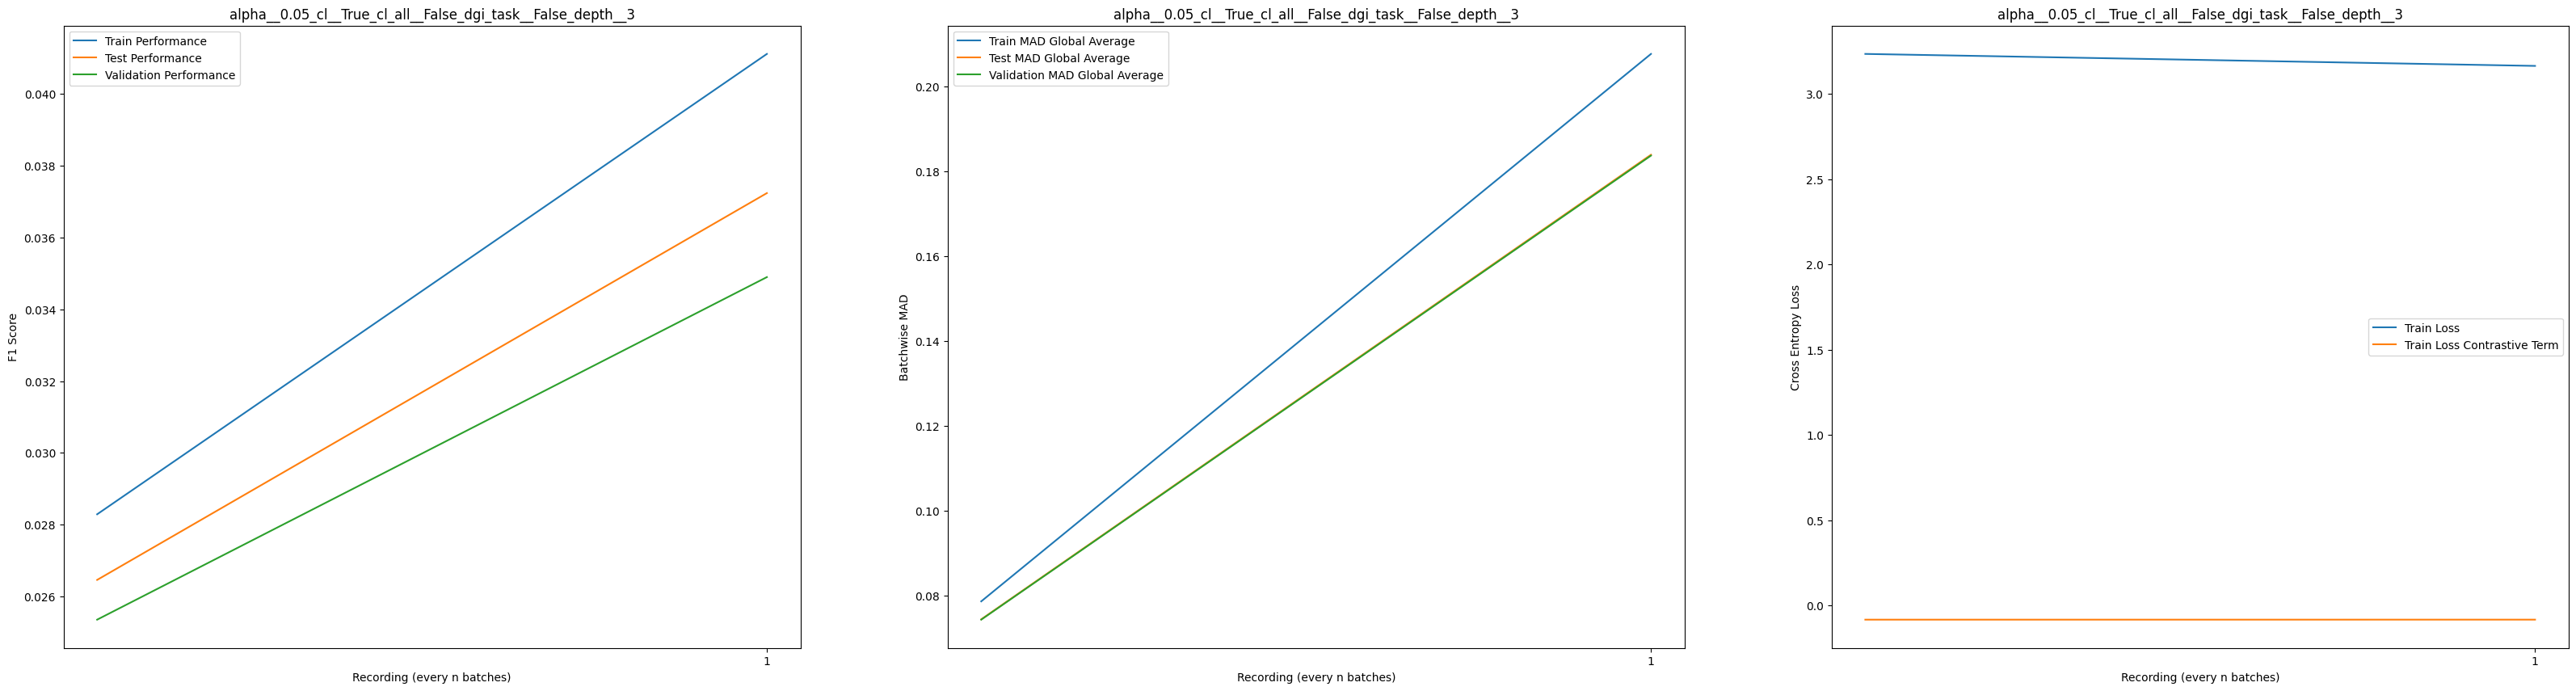